### Import Libraries

In [46]:
import torch, torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random, os
from pathlib import Path
from tqdm import tqdm

### Basic Setup Code

In [50]:
cifar10_train[0][0].shape,fmnist_train[0][0].shape,mnist_train[0][0].shape,kmnist_train[0][0].shape

(torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]))

In [51]:
cifar10_test[0][0].shape,fmnist_test[0][0].shape,mnist_test[0][0].shape,kmnist_test[0][0].shape

(torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]),
 torch.Size([3, 32, 32]))

In [52]:
torch.zeros((3,32,32))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

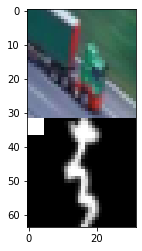

In [53]:
img = kmnist_train[50][0]
img[:,:5,:5] = 1.0
test_img = torch.hstack((cifar10_train[50][0],img))
plt.imshow(test_img.permute(1,2,0))

In [54]:
kmnist_train[50][0][:,:3,:3]=1.0
img = kmnist_train[50][0][:,:3,:3]
img[:,:3,:3]=100
img[:,:3,:3]

tensor([[[100., 100., 100.],
         [100., 100., 100.],
         [100., 100., 100.]],

        [[100., 100., 100.],
         [100., 100., 100.],
         [100., 100., 100.]],

        [[100., 100., 100.],
         [100., 100., 100.],
         [100., 100., 100.]]])

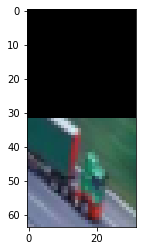

In [55]:
test_img = torch.hstack((torch.zeros((3,32,32)),cifar10_train[50][0]))
plt.imshow(test_img.permute(1,2,0))

# 2-Class Domino Datasets

## Create Datasets and Subfolder Heirarchies

In [56]:
## config settings for kmnistPatch
# # user hyperparams
# num_train = 3500
# num_val = 500
# num_test = 800
# spur_corr = 1.0
# save_dir = root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_mnist_bot_kmnistPatch/'
# full_save_path = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_mnist_bot_kmnistPatch_ro_1p0.csv'
# top_dataset = {'name':'mnist', 'train_data':mnist_train, 'test_data':mnist_test}
# bot_dataset = {'name':'kmnistPatch', 'train_data':kmnist_train, 'test_data':kmnist_test}

In [70]:
# user hyperparams
num_train = 3500
num_val = 500
num_test = 800
spur_corr = 1.0
save_dir = root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_svhn_bot_kmnist/'
full_save_path = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_svhn_bot_kmnist_2class_ro_1p0.csv'
top_dataset = {'name':'svhn', 'train_data':svhn_train, 'test_data':svhn_test}
bot_dataset = {'name':'kmnist', 'train_data':kmnist_train, 'test_data':kmnist_test}

In [71]:
num_imgs = {'train':num_train+num_val, 'test':num_test}  # number of imgs in subfolders

# append labels to dataset dictionaries
for dataset in [top_dataset,bot_dataset]:
    if dataset['name']=='cifar10':
        dataset['train_labels'] = torch.tensor(cifar10_train.targets)
        dataset['test_labels'] = torch.tensor(cifar10_test.targets)
    elif dataset['name']=='mnist':
        dataset['train_labels'] = mnist_train.train_labels
        dataset['test_labels'] = mnist_test.train_labels
    elif dataset['name']=='kmnist' or dataset['name']=='kmnistPatch':
        dataset['train_labels'] = kmnist_train.train_labels
        dataset['test_labels'] = kmnist_test.train_labels
    elif dataset['name']=='fmnist':
        dataset['train_labels'] = fmnist_train.train_labels
        dataset['test_labels'] = fmnist_test.train_labels
    elif dataset['name']=='svhn':
        dataset['train_labels'] = torch.tensor(svhn_train.labels)
        dataset['test_labels'] = torch.tensor(svhn_test.labels)

# populate the various train/test folders and domino label combinations
for partition in ['train','test']:    
    for bot_label in tqdm(range(2)):
        for top_label in tqdm(range(2)):            
            bot_inds = (bot_dataset[f'{partition}_labels']==bot_label).nonzero().squeeze()  # indices for bottom images
            top_inds = (top_dataset[f'{partition}_labels']==top_label).nonzero().squeeze()  # indices for top images
            Path(os.path.join(save_dir,f'{partition}/top{top_label}_bot{bot_label}/')).mkdir(parents=True, exist_ok=True)
            
            for file_idx,(bot_idx,top_idx) in tqdm(enumerate(zip(bot_inds[:num_imgs[partition]],top_inds[:num_imgs[partition]]))):
                if bot_dataset['name'] == 'kmnistPatch' and bot_label==1:
                    temp_img = bot_dataset[f'{partition}_data'][bot_idx][0]
                    temp_img[:,:5,:5]=1.0
                    img = torch.hstack((top_dataset[f'{partition}_data'][top_idx][0],temp_img))
                else:
                    img = torch.hstack((top_dataset[f'{partition}_data'][top_idx][0],bot_dataset[f'{partition}_data'][bot_idx][0]))
                final_path = os.path.join(save_dir,f'{partition}/top{top_label}_bot{bot_label}/{file_idx}.jpg')
                plt.imsave(final_path,np.array(img.permute(1,2,0)))

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

58it [00:00, 575.52it/s]

132it [00:00, 669.05it/s]

207it [00:00, 703.17it/s]

282it [00:00, 720.48it/s]

359it [00:00, 736.68it/s]

435it [00:00, 743.86it/s]

511it [00:00, 746.82it/s]

587it [00:00, 748.20it/s]

663it [00:00, 749.76it/s]

738it [00:01, 746.73it/s]

813it [00:01, 745.26it/s]

889it [00:01, 747.14it/s]

965it [00:01, 750.14it/s]

1042it [00:01, 753.79it/s]

1118it [00:01, 755.32it/s]

1194it [00:01, 755.13it/s]

1270it [00:01, 748.49it/s]

1345it [00:01, 747.43it/s]

1420it [00:01, 743.77it/s]

1496it [00:02, 745.95it/s]

1572it [00:02, 749.21it/s]

1650it [00:02, 757.99it/s]

1726it [00:02, 752.57it/s]

1802it [00:02, 751.63it/s]

1879it [00:02, 754.97it/s]

1956it [00:02, 749.23it/s]

2031it [00:02, 749.07it/s]

2107it [00:02, 751.54it/s]

2183it [00:02, 745.79it/s]

2258it [00:03, 742.16it/s]

2334it [00:03, 747.05it/s]

2410it [00:03, 749.27it/s]

2487it [00:03, 752.54it/s]

2563it [00:03, 753.58it/s]

263

75it [00:00, 745.88it/s]

151it [00:00, 749.70it/s]

226it [00:00, 744.98it/s]

301it [00:00, 743.06it/s]

376it [00:00, 738.91it/s]

451it [00:00, 740.10it/s]

526it [00:00, 741.40it/s]

601it [00:00, 736.90it/s]

676it [00:00, 740.38it/s]

800it [00:01, 742.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

71it [00:00, 702.75it/s]

145it [00:00, 721.52it/s]

218it [00:00, 721.78it/s]

292it [00:00, 725.10it/s]

367it [00:00, 731.74it/s]

442it [00:00, 736.90it/s]

517it [00:00, 739.29it/s]

594it [00:00, 746.00it/s]

669it [00:00, 617.08it/s]

800it [00:01, 695.44it/s]

 50%|█████     | 1/2 [00:01<00:01,  1.15s/it]

0it [00:00, ?it/s]

76it [00:00, 753.71it/s]

152it [00:00, 745.32it/s]

229it [00:00, 753.11it/s]

305it [00:00, 754.23it/s]

382it [00:00, 759.35it/s]

458it [00:00, 757.70it/s]

534it [00:00, 752.39it/s]

610it [00:00, 746.06it/s]

685it [00:00, 744.43it/s]

800it [00:01, 749.68it/s]

100%|██████████| 2/2 [00:04<00:00,  2.21s/it]


## Generate CSV file for corresponding dataset

In [72]:
# code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg
# code currently only supports spurious correlation = 1.0

val_inds = random.sample(range(num_train+num_val), num_val)
all_inds = list(range(num_train+num_val))
train_inds = [x for x in all_inds if x not in val_inds]
csv_list = [] # all rows will be appended here
csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

for lbl_idx in range(2):
    # add validation info to csv_list
    for val_idx in val_inds:
        path = os.path.join(root_dir,f'train/top{lbl_idx}_bot{lbl_idx}/{val_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 0
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add train info to csv_list
    for tr_idx in train_inds:
        path = os.path.join(root_dir,f'train/top{lbl_idx}_bot{lbl_idx}/{tr_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 1
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add test info to csv_list
    for test_idx in range(num_test):
        path = os.path.join(root_dir,f'test/top{lbl_idx}_bot{lbl_idx}/{test_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 2
        test_nontest_split = 0
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

df = pd.DataFrame(csv_list)
df.columns = csv_cols
df.to_csv(full_save_path,index=False)


## Create Top Blank Dataset Domino

In [61]:
# user hyperparams
num_train = 3500
num_val = 500
num_test = 800
spur_corr = 1.0
save_dir = root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_blank_bot_svhn/'
full_save_path = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_blank_bot_svhn_2class_ro_1p0.csv'
bot_dataset = {'name':'svhn', 'train_data':svhn_train, 'test_data':svhn_test}

In [62]:
num_imgs = {'train':num_train+num_val, 'test':num_test}  # number of imgs in subfolders

# append labels to dataset dictionaries
for dataset in [bot_dataset]:
    if dataset['name']=='cifar10':
        dataset['train_labels'] = torch.tensor(cifar10_train.targets)
        dataset['test_labels'] = torch.tensor(cifar10_test.targets)
    elif dataset['name']=='mnist':
        dataset['train_labels'] = mnist_train.train_labels
        dataset['test_labels'] = mnist_test.train_labels
    elif dataset['name']=='kmnist' or dataset['name']=='kmnistPatch':
        dataset['train_labels'] = kmnist_train.train_labels
        dataset['test_labels'] = kmnist_test.train_labels
    elif dataset['name']=='fmnist':
        dataset['train_labels'] = fmnist_train.train_labels
        dataset['test_labels'] = fmnist_test.train_labels
    elif dataset['name']=='svhn':
        dataset['train_labels'] = torch.tensor(svhn_train.labels)
        dataset['test_labels'] = torch.tensor(svhn_test.labels)

# populate the various train/test folders and domino label combinations
for partition in ['train','test']:    
    for bot_label in tqdm(range(2)):           
        bot_inds = (bot_dataset[f'{partition}_labels']==bot_label).nonzero().squeeze()  # indices for bottom images
        Path(os.path.join(save_dir,f'{partition}/{bot_label}/')).mkdir(parents=True, exist_ok=True)

        for file_idx,bot_idx in tqdm(enumerate(bot_inds[:num_imgs[partition]])):
            if bot_dataset['name'] == 'kmnistPatch' and bot_label==1:
                temp_img = bot_dataset[f'{partition}_data'][bot_idx][0]
                temp_img[:,:5,:5]=1.0
                img = torch.hstack((torch.zeros((3,32,32)),temp_img))
            else:
                img = torch.hstack((torch.zeros((3,32,32)),bot_dataset[f'{partition}_data'][bot_idx][0]))
            final_path = os.path.join(save_dir,f'{partition}/{bot_label}/{file_idx}.jpg')
            plt.imsave(final_path,np.array(img.permute(1,2,0)))

  0%|          | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
78it [00:00, 779.23it/s]
160it [00:00, 800.77it/s]
245it [00:00, 822.45it/s]
332it [00:00, 838.81it/s]
417it [00:00, 841.77it/s]
502it [00:00, 802.77it/s]
586it [00:00, 812.07it/s]
673it [00:00, 829.86it/s]
759it [00:00, 836.77it/s]
846it [00:01, 843.38it/s]
931it [00:01, 844.91it/s]
1017it [00:01, 848.29it/s]
1102it [00:01, 838.40it/s]
1187it [00:01, 841.60it/s]
1273it [00:01, 845.44it/s]
1361it [00:01, 853.95it/s]
1448it [00:01, 858.67it/s]
1534it [00:01, 858.85it/s]
1622it [00:01, 862.85it/s]
1710it [00:02, 865.25it/s]
1797it [00:02, 864.33it/s]
1884it [00:02, 861.56it/s]
1971it [00:02, 861.58it/s]
2058it [00:02, 859.12it/s]
2144it [00:02, 854.22it/s]
2230it [00:02, 853.93it/s]
2316it [00:02, 854.09it/s]
2402it [00:02, 854.66it/s]
2489it [00:02, 856.72it/s]
2576it [00:03, 859.48it/s]
2663it [00:03, 860.44it/s]
2750it [00:03, 792.14it/s]
2834it [00:03, 805.24it/s]
2919it [00:03, 816.31it/s]
3002it [00:03, 820.11it/s]
3087it [00

## Generate CSV File for corresponding Blank Domino Dataset

In [63]:
# code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg
# code currently only supports spurious correlation = 1.0

val_inds = random.sample(range(num_train+num_val), num_val)
all_inds = list(range(num_train+num_val))
train_inds = [x for x in all_inds if x not in val_inds]
csv_list = [] # all rows will be appended here
csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

for lbl_idx in range(2):
    # add validation info to csv_list
    for val_idx in val_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{val_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 0
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add train info to csv_list
    for tr_idx in train_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{tr_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 1
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add test info to csv_list
    for test_idx in range(num_test):
        path = os.path.join(root_dir,f'test/{lbl_idx}/{test_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 2
        test_nontest_split = 0
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

df = pd.DataFrame(csv_list)
df.columns = csv_cols
df.to_csv(full_save_path,index=False)


## Create Bottom Blank Dataset Domino

In [64]:
# user hyperparams
num_train = 3500
num_val = 500
num_test = 800
spur_corr = 1.0
save_dir = root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_svhn_bot_blank/'
full_save_path = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/experiments/toy_expts/domino_expts/top_svhn_bot_blank_2class_ro_1p0.csv'
top_dataset = {'name':'svhn', 'train_data':svhn_train, 'test_data':svhn_test}

In [65]:
num_imgs = {'train':num_train+num_val, 'test':num_test}  # number of imgs in subfolders

# append labels to dataset dictionaries
for dataset in [top_dataset]:
    if dataset['name']=='cifar10':
        dataset['train_labels'] = torch.tensor(cifar10_train.targets)
        dataset['test_labels'] = torch.tensor(cifar10_test.targets)
    elif dataset['name']=='mnist':
        dataset['train_labels'] = mnist_train.train_labels
        dataset['test_labels'] = mnist_test.train_labels
    elif dataset['name']=='kmnist' or dataset['name']=='kmnistPatch':
        dataset['train_labels'] = kmnist_train.train_labels
        dataset['test_labels'] = kmnist_test.train_labels
    elif dataset['name']=='fmnist':
        dataset['train_labels'] = fmnist_train.train_labels
        dataset['test_labels'] = fmnist_test.train_labels
    elif dataset['name']=='svhn':
        dataset['train_labels'] = torch.tensor(svhn_train.labels)
        dataset['test_labels'] = torch.tensor(svhn_test.labels)

# populate the various train/test folders and domino label combinations
for partition in ['train','test']:    
    for top_label in tqdm(range(2)):           
        top_inds = (top_dataset[f'{partition}_labels']==top_label).nonzero().squeeze()  # indices for bottom images
        Path(os.path.join(save_dir,f'{partition}/{top_label}/')).mkdir(parents=True, exist_ok=True)

        for file_idx,top_idx in tqdm(enumerate(top_inds[:num_imgs[partition]])):
            if top_dataset['name'] == 'kmnistPatch' and top_label==1:
                temp_img = top_dataset[f'{partition}_data'][top_idx][0]
                temp_img[:,:5,:5]=1.0
                img = torch.hstack((temp_img,torch.zeros((3,32,32))))
            else:
                img = torch.hstack((top_dataset[f'{partition}_data'][top_idx][0],torch.zeros((3,32,32))))
            final_path = os.path.join(save_dir,f'{partition}/{top_label}/{file_idx}.jpg')
            plt.imsave(final_path,np.array(img.permute(1,2,0)))

  0%|          | 0/2 [00:00<?, ?it/s]
0it [00:00, ?it/s]
80it [00:00, 795.42it/s]
164it [00:00, 820.35it/s]
249it [00:00, 832.55it/s]
334it [00:00, 836.73it/s]
421it [00:00, 846.10it/s]
507it [00:00, 847.35it/s]
592it [00:00, 834.05it/s]
678it [00:00, 840.06it/s]
765it [00:00, 846.55it/s]
852it [00:01, 851.96it/s]
939it [00:01, 855.16it/s]
1027it [00:01, 860.20it/s]
1114it [00:01, 854.70it/s]
1200it [00:01, 854.73it/s]
1286it [00:01, 845.76it/s]
1371it [00:01, 822.52it/s]
1454it [00:01, 770.97it/s]
1539it [00:01, 790.73it/s]
1624it [00:01, 807.01it/s]
1709it [00:02, 818.74it/s]
1795it [00:02, 829.37it/s]
1879it [00:02, 795.63it/s]
1963it [00:02, 808.23it/s]
2048it [00:02, 818.17it/s]
2134it [00:02, 829.03it/s]
2221it [00:02, 839.07it/s]
2309it [00:02, 849.75it/s]
2396it [00:02, 855.57it/s]
2482it [00:02, 849.50it/s]
2569it [00:03, 853.54it/s]
2656it [00:03, 856.80it/s]
2742it [00:03, 856.69it/s]
2828it [00:03, 855.15it/s]
2915it [00:03, 858.85it/s]
3003it [00:03, 862.72it/s]
3090it [00

## Generate CSV File for corresponding Blank Domino Dataset

In [66]:
# code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg
# code currently only supports spurious correlation = 1.0

val_inds = random.sample(range(num_train+num_val), num_val)
all_inds = list(range(num_train+num_val))
train_inds = [x for x in all_inds if x not in val_inds]
csv_list = [] # all rows will be appended here
csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

for lbl_idx in range(2):
    # add validation info to csv_list
    for val_idx in val_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{val_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 0
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add train info to csv_list
    for tr_idx in train_inds:
        path = os.path.join(root_dir,f'train/{lbl_idx}/{tr_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 1
        test_nontest_split = 1
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
    # add test info to csv_list
    for test_idx in range(num_test):
        path = os.path.join(root_dir,f'test/{lbl_idx}/{test_idx}.jpg')
        top = bottom = lbl_idx
        val_train_test_split = 2
        test_nontest_split = 0
        all_zeros = 0
        csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

df = pd.DataFrame(csv_list)
df.columns = csv_cols
df.to_csv(full_save_path,index=False)


# Code for Multiclass

### Create Dataset and their Subfolder Heirarchies

In [ ]:
# # user hyperparams
# save_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_mnist_bot_kmnist/'
# top_dataset = {'name':'mnist', 'train_data':cifar10_train, 'test_data':cifar10_test}
# bot_dataset = {'name':'kmnist', 'train_data':kmnist_train, 'test_data':kmnist_test}
# num_imgs = {'train':4000, 'test':800}  # number of imgs in subfolders

# # append labels to dataset dictionaries
# for dataset in [top_dataset,bot_dataset]:
#     if dataset['name']=='cifar10':
#         dataset['train_labels'] = torch.tensor(cifar10_train.targets)
#         dataset['test_labels'] = torch.tensor(cifar10_test.targets)
#     elif dataset['name']=='mnist':
#         dataset['train_labels'] = mnist_train.train_labels
#         dataset['test_labels'] = mnist_test.train_labels
#     elif dataset['name']=='kmnist':
#         dataset['train_labels'] = kmnist_train.train_labels
#         dataset['test_labels'] = kmnist_test.train_labels
#     elif dataset['name']=='fmnist':
#         dataset['train_labels'] = fmnist_train.train_labels
#         dataset['test_labels'] = fmnist_test.train_labels

# # populate the various train/test folders and domino label combinations
# for partition in ['train','test']:    
#     for bot_label in tqdm(range(10)):
#         for top_label in tqdm(range(10)):            
#             bot_inds = (bot_dataset[f'{partition}_labels']==bot_label).nonzero().squeeze()  # indices for bottom images
#             top_inds = (top_dataset[f'{partition}_labels']==top_label).nonzero().squeeze()  # indices for top images
#             Path(os.path.join(save_dir,f'{partition}/top{top_label}_bot{bot_label}/')).mkdir(parents=True, exist_ok=True)
            
#             for file_idx,(bot_idx,top_idx) in tqdm(enumerate(zip(bot_inds[:num_imgs[partition]],top_inds[:num_imgs[partition]]))):
#                 img = torch.hstack((top_dataset[f'{partition}_data'][top_idx][0],bot_dataset[f'{partition}_data'][bot_idx][0]))
#                 final_path = os.path.join(save_dir,f'{partition}/top{top_label}_bot{bot_label}/{file_idx}.jpg')
#                 plt.imsave(final_path,np.array(img.permute(1,2,0)))

### Generate corresponding CSVs for the Datasets

In [ ]:
# # code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg
# # code currently only supports spurious correlation = 1.0

# # user hyperparams
# spur_corr = 1.0
# num_train = 3500 # number of images in root_dir/train/top{0-9}_bot{0-9}/
# num_val = 500
# num_test = 800 # number of images in root_dir/test/top{0-9}_bot{0-9}/
# root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_mnist_bot_kmnist'
# full_save_path = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/csv_files/top_mnist_bot_kmnist_spcorr_1p0.csv'

# val_inds = random.sample(range(num_train+num_val), num_val)
# all_inds = list(range(num_train+num_val))
# train_inds = [x for x in all_inds if x not in val_inds]
# csv_list = [] # all rows will be appended here
# csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

# for lbl_idx in range(10):
#     # add validation info to csv_list
#     for val_idx in val_inds:
#         path = os.path.join(root_dir,f'train/top{lbl_idx}_bot{lbl_idx}/{val_idx}.jpg')
#         top = bottom = lbl_idx
#         val_train_test_split = 0
#         test_nontest_split = 1
#         all_zeros = 0
#         csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
#     # add train info to csv_list
#     for tr_idx in train_inds:
#         path = os.path.join(root_dir,f'train/top{lbl_idx}_bot{lbl_idx}/{tr_idx}.jpg')
#         top = bottom = lbl_idx
#         val_train_test_split = 1
#         test_nontest_split = 1
#         all_zeros = 0
#         csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])
#     # add test info to csv_list
#     for test_idx in range(num_test):
#         path = os.path.join(root_dir,f'test/top{lbl_idx}_bot{lbl_idx}/{test_idx}.jpg')
#         top = bottom = lbl_idx
#         val_train_test_split = 2
#         test_nontest_split = 0
#         all_zeros = 0
#         csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

# df = pd.DataFrame(csv_list)
# df.columns = csv_cols
# df.to_csv(full_save_path,index=False)


In [ ]:
# # this code is to create test csv files, having all test images
# # code assumes the heirarchy root_dir/{train/test}/top{0-9}_bot{0-9}/{0-num_train/0-num_test}.jpg

# # user hyperparams
# num_test = 800 # number of images in root_dir/test/top{0-9}_bot{0-9}/
# root_dir = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/data/domino_datasets/top_cifar10_bot_fmnist'
# full_save_path = '/xxx/home/xxx/xxx/xxx/projects/shortcut_detection_and_mitigation/csv_files/top_cifar10_bot_fmnist_test.csv'

# csv_list = [] # all rows will be appended here
# csv_cols = ['path','top','bottom','val_train_test_split','test_nontest_split','all_zeros']

# for idx1 in tqdm(range(10)):
#     for idx2 in tqdm(range(10)):
#         # add test info to csv_list
#         for test_idx in range(num_test):
#             path = os.path.join(root_dir,f'test/top{idx1}_bot{idx2}/{test_idx}.jpg')
#             top = idx1
#             bottom = idx2
#             val_train_test_split = 2
#             test_nontest_split = 0
#             all_zeros = 0
#             csv_list.append([path,top,bottom,val_train_test_split,test_nontest_split,all_zeros])

# df = pd.DataFrame(csv_list)
# df.columns = csv_cols
# df.to_csv(full_save_path,index=False)


In [ ]:
# ll = [['a',1,3,4],['aba',5,4,9]]
# df = pd.DataFrame(ll)
# df.columns = ['path','top','bottom',5]
# df